# Predicting Medical Appointment No Shows

---

### [Dataset](https://www.kaggle.com/joniarroba/noshowappointments/home)

### Context
A person makes a doctor appointment, receives all the instructions and is a no show.  Is it possible to predict if someone will be a no-show?

### Content
This dataset contains 300,000 medical appointments and 15 characteristics of each appointment.  The appointments took place in Brazil and occurred between April 29, 2016 and June 8, 2016. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import calendar
import seaborn as sns
sns.set_style('white')

# Note: redownload Kaggle data version 3
try:
    file = 'C:/Users/Carter Carlson/Documents/Thinkful/Large Databases/No show dr appt.csv'
    df = pd.read_csv(file)
except:
    file = 'C:/Users/18047/Downloads/No show.csv'
    df = pd.read_csv(file)

print('# of Records:\n', len(df))
df.head()

# of Records:
 300000


,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [2]:
# Data cleaning/adding features
df = df.drop(['AwaitingTime'], 1)
df = df[df['Age'] > 0]
df = df.rename(columns={'Gender':'IsFemale', 
                        'AppointmentRegistration': 'ScheduledDay',
                        'ApointmentData': 'AppointmentDay',
                        'Status': 'No-show',
                        'Alcoolism': 'Alcoholism',
                        'HiperTension': 'Hypertension',
                        'Sms_Reminder': 'SMS_received',
                        'Handcap': 'Handicap',
                        'DayOfTheWeek': 'Weekday'})

# Convert ScheduledDay and AppointmentDay into dates
df['ScheduledDay'] = df['ScheduledDay'].str[:10]
df['AppointmentDay'] = df['AppointmentDay'].str[:10]
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Create new features
df['DaysBeforeAppt'] = abs(df['ScheduledDay'] - df['AppointmentDay']).dt.days
df['VeryHealthy'] = ((df['Hypertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handicap'] + df['Smokes']) == 0)
df['VeryUnhealthy'] = ((df['Hypertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handicap'] + df['Smokes']) >= 2)

# Convert columns to boolean
cols_to_convert = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'Tuberculosis', 'Smokes', 'SMS_received']
for col in cols_to_convert:
    df[col] = (df[col] > 0)

df['IsFemale'] = (df['IsFemale'] == "F")
df['No-show'] = (df['No-show'] == "No-Show")

## Dataset Analysis

In [ ]:
# Analyze no-show by gender, age, day of week
# 1. Pie chart of gender - done
# 2. Histogram of ages
# 3. Histogram of day of week
# 4. x=no-show, y=age, filter by gender

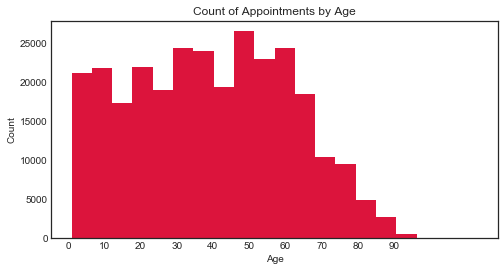

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(data=df, x='Age', bins=20, color='crimson')
plt.xticks(range(0,100,10))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Appointments by Age')
plt.show()

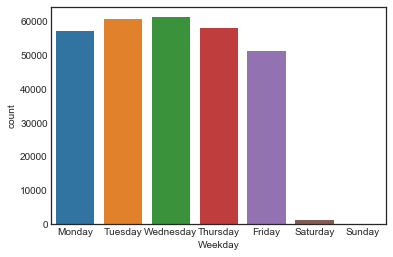

In [26]:
g = df.groupby('Weekday')['Weekday'].count()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Weekday', order=order)
plt.show()

---
## Correlation Analysis

Let's filter our dataset to only variables with low correlation to each other.  It may help our model be less biased by removing any weight two correlated variables would create on predictions.

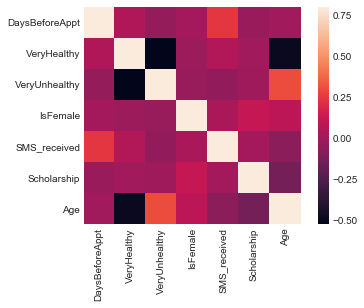

In [14]:
X = df[['DaysBeforeAppt', 'VeryHealthy', 'VeryUnhealthy', 'IsFemale', 'SMS_received', 'Scholarship', 'Age']]
Y = df['No-show']

correlations = X.corr()

sns.heatmap(correlations, vmax=.8, square=True)
plt.show()

### Positive and Negative Correlations
What immediately strikes out from the heatmap is that Age is the only variable that has strong correlations with more than one variable.  The variables correlated with Age are also, unsurprisingly, VeryHealthy and VeryUnHealthy, so for now I'll remove the Age variable before regression analysis.  VeryHealthy and VeryUnhealthy are also strongly correlated with each-other, so I'll also remove one of them.

I was interested to see that SMS_received and DaysBeforeAppt are slightly correlated, and I decided  to investigate further:

In [79]:
num_days = []
num_appts = []
num_texts = []

for i in range(1,6):    
    num_days.append(i)
    num_appts.append(df[df['DaysBeforeAppt'] == i].count()['DaysBeforeAppt'])
    num_texts.append(df[(df['DaysBeforeAppt'] == i) & (df['SMS_received'] == True)].count()['SMS_received'])

pd.DataFrame(
    {'Days before appt': num_days,
     'Appts scheduled': num_appts,
     'Texts received': num_texts
    })

,Days before appt,Appts scheduled,Texts received
0,1,30830,0
1,2,28067,0
2,3,14055,6236
3,4,22555,17695
4,5,13264,9771


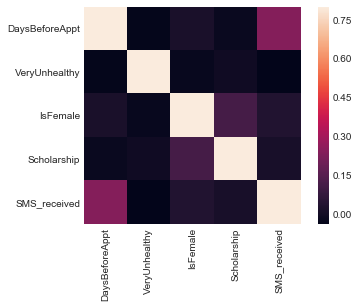

In [124]:
X = df[['DaysBeforeAppt', 'VeryUnhealthy', 'IsFemale', 'Scholarship', 'SMS_received']]
Y = df['No-show']
correlations = X.corr()

sns.heatmap(correlations, vmax=.8, square=True)
plt.show()

Much better!

---

## Variable Importance

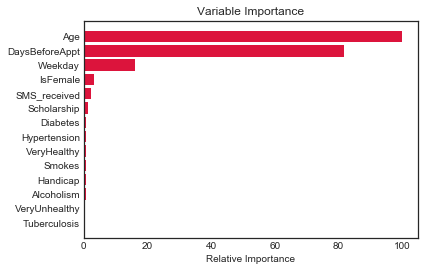

In [269]:
from sklearn.ensemble import RandomForestClassifier
# Play with parameters
tree = RandomForestClassifier()
X = df.drop(['No-show', 'ScheduledDay', 'AppointmentDay'], 1)
Y = df['No-show']
tree.fit(X, Y)

feature_importance = tree.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_features = np.argsort(feature_importance)
pos = np.arange(sorted_features.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_features], align='center', color='crimson')
plt.title('Variable Importance')
plt.xlabel('Relative Importance')
plt.yticks(pos, X.columns[sorted_features])
plt.show()

We saw earlier that Age had a high correlation with VeryHealthy and VeryUnhealthy, and decided to remove it.  Now we see that Age is the most important factor to predict no-shows while VeryHealthy and VeryUnhealthy have almost no relative importance.  Moving forward I'll use the 3 most important variables to predict no-shows.

---
## Class imbalance
To properly fit our machine learning algorithms, we need to make sure there are a similar amount of "True" and "False" No-shows.  Right now, there are about 2.5x more "False" No-shows, which means the algorithm could simply classify everything as "False" and still be correct more than 70% of the time.

In [276]:
original_f, original_t = len(df[df['No-show'] == False]), len(df[df['No-show'] == True])
print('# of No-shows (before SMOTE)', '\nFalse  ' ,original_f,'\nTrue   ', original_t)

# of No-shows (before SMOTE) 
False   201889 
True    87779


In [286]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

X = df[['Age', 'DaysBeforeAppt', 'Weekday']]
Y = df['No-show']
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)
X_resampled, Y_resampled = sm.fit_sample(X, Y)
X_vis_resampled = pca.fit_transform(X_resampled)

resampled_f, resampled_t = len(Y_resampled[Y_resampled == False]), len(Y_resampled[Y_resampled == True])
print('# of No-shows (after SMOTE)', '\nFalse  ', resampled_f,'\nTrue   ', resampled_t)

# of No-shows (after SMOTE) 
False   42665 
True    40448


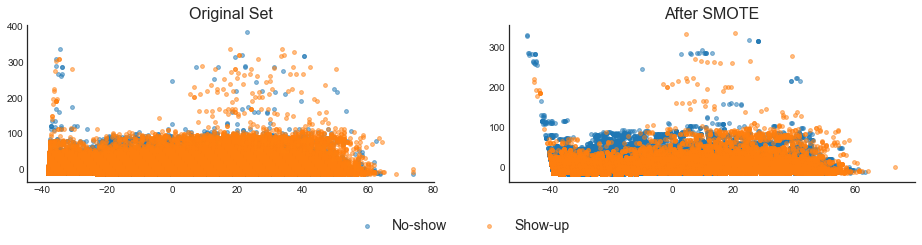

In [287]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

c0 = ax1.scatter(X_vis[Y == 1, 0], X_vis[Y == 1, 1], alpha=0.5, s=15, label='No-show')
c1 = ax1.scatter(X_vis[Y == 0, 0], X_vis[Y == 0, 1], alpha=0.5, s=15, label='Show-up')
ax1.set_title('Original Set', fontsize=16)

ax2.scatter(X_vis_resampled[Y_resampled == 1, 0], X_vis_resampled[Y_resampled == 1, 1], alpha=0.5, s=15, label='No-show')
ax2.scatter(X_vis_resampled[Y_resampled == 0, 0], X_vis_resampled[Y_resampled == 0, 1], alpha=0.5, s=15, label='Show-up')
ax2.set_title('After SMOTE', fontsize=16)

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()  

f.legend((c0, c1),('No-show', 'Show-up'), loc='lower center', prop={'size': 14}, ncol=2)
plt.tight_layout(pad=5)
plt.show()

# Regression

In [290]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import math

# Create classifier
logr = LogisticRegression()
bnb = BernoulliNB()
tree = RandomForestClassifier()
knn = KNeighborsClassifier()

# Collection of possible parameters
logr_param = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'tol': [math.exp(-5), math.exp(-4), math.exp(-3)]}

bnb_param = {'alpha': [0.01, 0.5, 1, 2]}

tree_param = {'n_estimators': [10, 100, 200],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

knn_param = {'n_neighbors': [2, 5, 10],
             'leaf_size': [10, 30, 50],
             'weights': ['uniform', 'distance'],
             'algorithm': ['auto']}


# Determine the best parameters
logr_best = GridSearchCV(estimator=logr, param_grid=logr_param, cv=3)
bnb_best = GridSearchCV(estimator=bnb, param_grid=bnb_param, cv=3)
tree_best = GridSearchCV(estimator=tree, param_grid=tree_param, cv=3)
knn_best = GridSearchCV(estimator=knn, param_grid=knn_param, cv=3)

classifiers = [logr_best, bnb_best, tree_best, knn_best]
classifier_name = ['Logistic Regression', 'Bernoulli Naive Bayes', 'Random Forest', 'K Nearest Neighbors']

for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_resampled, Y_resampled)
    y_pred = classifier.predict(X_resampled)
    matrix = confusion_matrix(Y_resampled, y_pred)

    print(classifier_name[i])
    print('\nTrue positive: ', matrix[0][0])
    print('False positive: ', matrix[0][1])
    print('True Negative: ', matrix[1][1])
    print('False Negative: ', matrix[1][0])
    print('\n\nClassification Report\n', classification_report(Y_resampled, y_pred))
    print('-------------------------------------------------------')    

Logistic Regression

True positive:  29593
False positive:  13072
True Negative:  28072
False Negative:  12376


Classification Report
              precision    recall  f1-score   support

      False       0.71      0.69      0.70     42665
       True       0.68      0.69      0.69     40448

avg / total       0.69      0.69      0.69     83113

-------------------------------------------------------
Bernoulli Naive Bayes

True positive:  34870
False positive:  7795
True Negative:  9339
False Negative:  31109


Classification Report
              precision    recall  f1-score   support

      False       0.53      0.82      0.64     42665
       True       0.55      0.23      0.32     40448

avg / total       0.54      0.53      0.49     83113

-------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
colors = ['green', 'blue', 'red', 'orange']

plt.figure(figsize=(6,5))

for i in range(0, len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_resampled, Y_resampled)
    y_pred = classifier.predict(X_resampled)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(Y_resampled, y_pred)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    plt.plot(false_pos_rate, true_pos_rate, color=colors[i], label=classifier_name[i])

random_pred = [0.0, 1.0]
plt.plot(random_pred, random_pred, '--', label='Random', color='black')

plt.legend(fontsize=10, loc='best')
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.show()